# Problem Statement

Given the following sentences:

- "I hate the selfishness in you" — Label: Negative
- "I hate any one who can hurt you" — Label: Positive

We need to build a sentiment analysis pipeline that can correctly classify these sentences by effectively handling homonyms and contextual nuances.

the Key Challenges here:
- Ambiguity of Homonyms: Words like "hate" can appear in different contexts, leading to varying sentiment labels. Without understanding the context, a model might misinterpret the sentiment.
- Contextual Sentiment Analysis: Simple sentiment models might focus on keywords rather than deeper context, leading to incorrect predictions for sentences like the second one.

let's try modern models like transformers (e.g., BERT or RoBERTa) which can capture word meanings based on surrounding words.

**so let's try fine-tuned roberta model for sntiment analysis task**

In [1]:
from transformers import pipeline

model_path = 'cardiffnlp/twitter-roberta-base-sentiment-latest'  ## THE MOST DOWNLOADED

sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT 

In [2]:
sentiment_task(["I hate the selfishness in you", "I hate anyone who can hurt you"])

[{'label': 'negative', 'score': 0.9365804195404053},
 {'label': 'negative', 'score': 0.9193458557128906}]

**as we can see, it mis-classified one of the two sentences which the hardest one.**

**=> So let's fine-tuning a bert model for sentiment analysis on a dataset includes diverse sentences with this Homonyms charactristics which will help the model learn contextual differences.**

# Fine-tuning Roberta on a generated dataset

**I generated a dataset by GPT-4o that has some of the characteristics like short, sarcasm, and homonyms ambiguity to ensure the dataset includes diverse sentences that help the model learn contextual differences.**

In [3]:
# Paths
main_dir = '/content/sentiment_analysis'
data_path = main_dir + '/data'
splits_path = data_path + '/splits'
model_path = main_dir + '/model'

In [4]:
# Step 1: Load and preprocess the dataset from the txt file
import pandas as pd

# df = pd.read_csv(data_path+ "/data.csv")
df = pd.read_csv(data_path + '/generated_dataset.csv')

pd.set_option('display.max_colwidth', 1000)
df.sample(15)

,text,label
1396,The baby’s first laugh was a moment they’ll never forget,Positive
498,"The toast was burnt, but his wedding toast was heartfelt and perfect.",Positive
1126,Her surprise visit to her best friend was the highlight of the week,Positive
722,The light in the room made everything seem cheerful,Positive
2288,The bandage on his arm needed to be changed,Neutral
2061,"The star shone in the sky, but the movie star left her feeling cold.",Neutral
2182,The fruit bowl had only an apple left in it,Neutral
2354,He found a dollar bill lying on the street,Neutral
1341,The spilled juice made a sticky mess all over the table,Negative
752,He was chosen to lead the new department,Positive


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2362 non-null   object
 1   label   2362 non-null   object
dtypes: object(2)
memory usage: 37.0+ KB


**Checking NaNs**

In [6]:
df.isnull().sum()

,0
text,0
label,0


**Checking duplicates**

In [7]:
df.duplicated("text").sum()

79

In [8]:
df.drop_duplicates(subset="text", inplace=True)

**Checking dataset balancing**

In [9]:
value_counts= df['label'].value_counts()
value_counts

,count
label,
Neutral,816
Positive,797
Negative,670


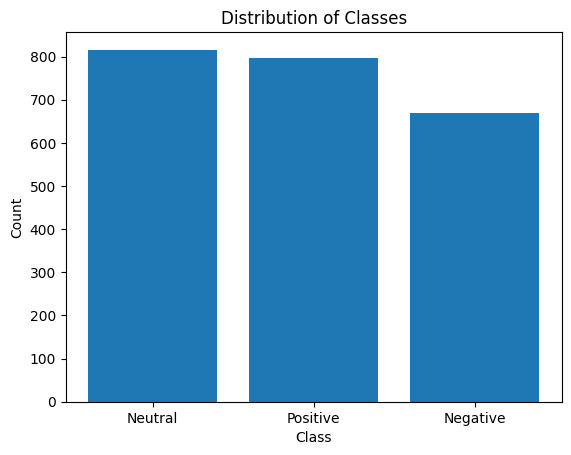

In [10]:
# make a visualization
import matplotlib.pyplot as plt

# Create bar plot
plt.bar(value_counts.index, value_counts.values)
# Add title and labels
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Show plot
plt.show()

**Checking the length distribution**

In [11]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

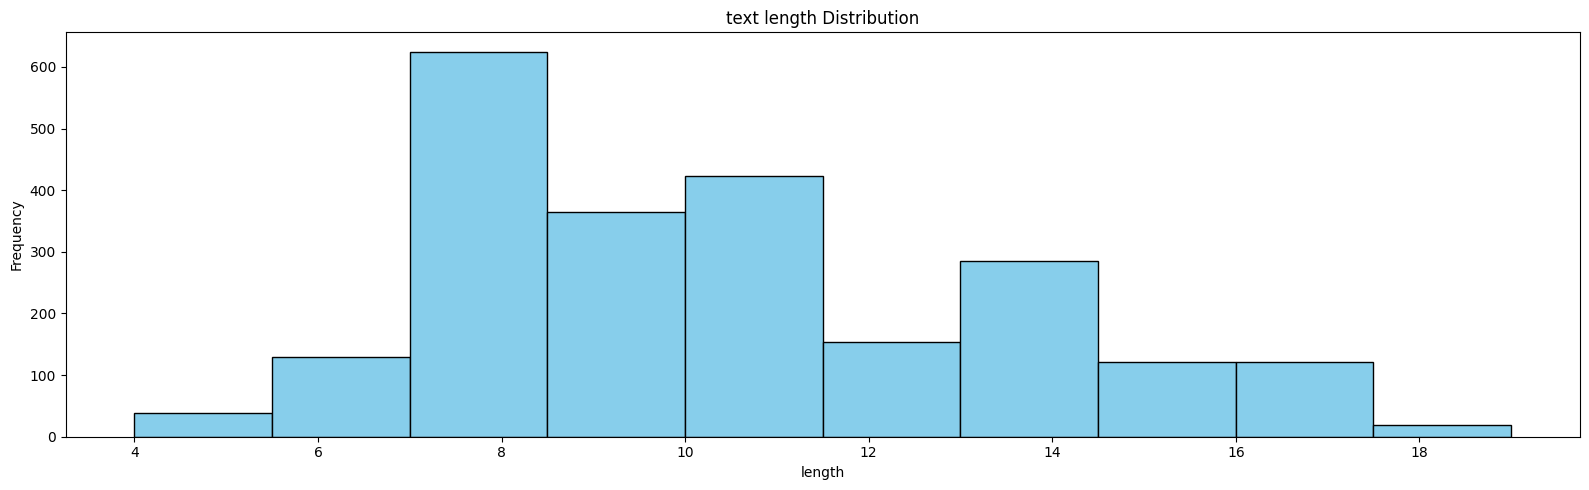

In [12]:
plt.figure(figsize=(16, 5))
plt.hist(df['text_length'], bins=10, color='skyblue', edgecolor='black')
plt.title('text length Distribution')
plt.xlabel('length')
plt.ylabel('Frequency')
plt.tight_layout()

# Display the plot
plt.show()

**Encoding the labels**

In [13]:
# Rename the 'label' to 'label_name'
df.rename(columns={'label': 'label_name'}, inplace=True)

# Drop the 'Tweet_length' column
df.drop(columns=['text_length'], inplace=True)

# Map the 'label_name' values to numbers
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['label'] = df['label_name'].map(label_mapping)

In [14]:
df

,text,label_name,label
0,I hate the selfishness in you,Negative,0
1,I hate anyone who can hurt you,Positive,2
2,I despise the way you only think of yourself.,Negative,0
3,I can't stand how self-centered you are.,Negative,0
4,Your lack of consideration disgusts me.,Negative,0
...,...,...,...
2357,The law firm handled the case with professionalism,Neutral,1
2358,He wrapped the bandage around his injured hand,Neutral,1
2359,The hammer hit the nail with precision,Neutral,1
2360,They launched a new campaign for the product,Neutral,1


## Splitting the Dataset

In [15]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test (80:20)
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42, shuffle=True)

In [16]:
print("Train set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)

Train set shape: (1826, 3)
Validation set shape: (457, 3)


**checking the distrebutions**

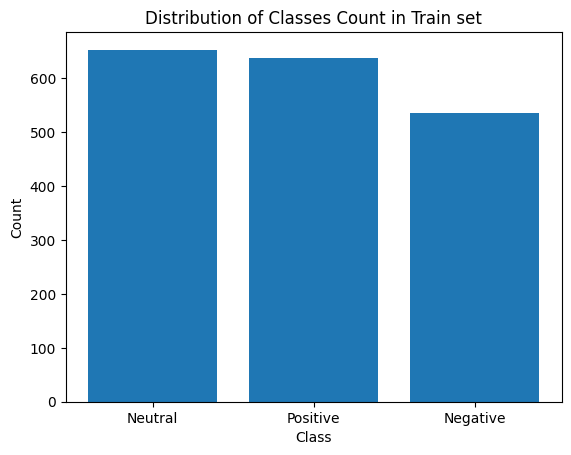

In [17]:
# make a visualization
import matplotlib.pyplot as plt

class_counts = train_df['label_name'].value_counts()

# Create bar plot
plt.bar(class_counts.index, class_counts.values)
# Add title and labels
plt.title('Distribution of Classes Count in Train set')
plt.xlabel('Class')
plt.ylabel('Count')

# Show plot
plt.show()

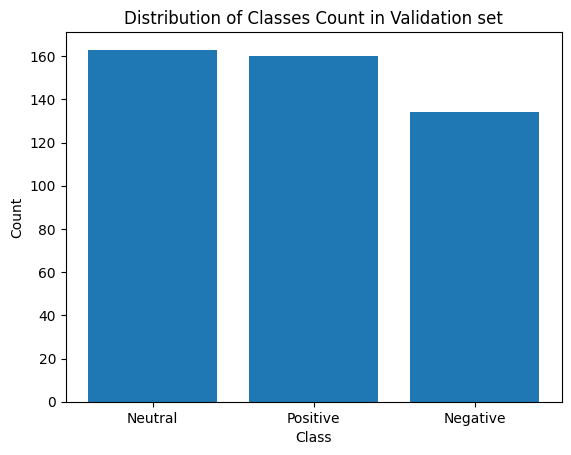

In [18]:
class_counts = valid_df['label_name'].value_counts()

# Create bar plot
plt.bar(class_counts.index, class_counts.values)
# Add title and labels
plt.title('Distribution of Classes Count in Validation set')
plt.xlabel('Class')
plt.ylabel('Count')

# Show plot
plt.show()

**Saving the splits for the reproducibility**

In [19]:
train_df.to_csv(splits_path +'/train_data.csv', index=False)
valid_df.to_csv(splits_path +'/valid_data.csv', index=False)

## Loading the sets

In [20]:
! pip install datasets

In [21]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files={
    'train': splits_path + '/train_data.csv',
    'valid': splits_path + '/valid_data.csv'
})

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 1826
    })
    valid: Dataset({
        features: ['text', 'label_name', 'label'],
        num_rows: 457
    })
})

In [23]:
# Drop 'label_name' column from all splits
dataset = dataset.remove_columns(['label_name'])

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1826
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 457
    })
})

## Preprocessing the data (Tokenization)

You can find the model used [here](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [25]:
from transformers import AutoTokenizer

model_checkpoint = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, max_length=256)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [26]:
tokenizer("what is going on ?")

{'input_ids': [0, 12196, 16, 164, 15, 17487, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [27]:
def tokenize_function(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=256)

In [28]:
# Apply the function to the dataset

tokenized_train_dataset = dataset['train'].map(tokenize_function, batched=True)
tokenized_val_dataset = dataset['valid'].map(tokenize_function, batched=True)

Map:   0%|          | 0/1826 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

## Model Defining

In [29]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir= model_path + "/finetuning-Roberta-model",
    num_train_epochs=15,  # Start with a lower number and adjust as needed
    learning_rate=1e-5,  # Adjust based on initial results
    per_device_eval_batch_size=16,  # Adjust based on memory constraints
    per_device_train_batch_size=16,  # Adjust based on memory constraints
    weight_decay=0.1,
    eval_strategy="epoch",  # Use "epoch" or "steps"
    save_strategy="epoch",  # Matching the eval_strategy
    load_best_model_at_end=True,  # Ensures the best model is saved
    disable_tqdm= False,
    push_to_hub=False
    # warmup_steps=500  # Gradual increase in learning rate
  )

## Training

In [32]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_val_dataset,
    tokenizer = tokenizer
)

In [33]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.478105,0.785558,0.784395,0.784456,0.793322
2,No log,0.404350,0.829322,0.827129,0.830681,0.836009
3,No log,0.387077,0.840263,0.838867,0.840536,0.845830
4,No log,0.404264,0.851204,0.850484,0.851014,0.856055
5,No log,0.432346,0.864333,0.863083,0.865238,0.869325
6,No log,0.631419,0.827133,0.821324,0.834218,0.835484
7,No log,0.515494,0.870897,0.870943,0.870359,0.874902
8,No log,0.644864,0.844639,0.843482,0.846666,0.848746
9,0.226800,0.578210,0.873085,0.873230,0.872926,0.876139
10,0.226800,0.643239,0.857768,0.857165,0.856895,0.861786


CPU times: user 19min 15s, sys: 51.6 s, total: 20min 6s
Wall time: 25min 7s


TrainOutput(global_step=870, training_loss=0.14568728523692864, metrics={'train_runtime': 1505.4598, 'train_samples_per_second': 18.194, 'train_steps_per_second': 0.578, 'total_flos': 3603338255784960.0, 'train_loss': 0.14568728523692864, 'epoch': 15.0})

## Testing the model

In [34]:
import torch

def predict(text):

  # Ensure the model is on the same device as the inputs
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Move the model to the correct device
  model.to(device)

  # Tokenize the input text and move the inputs to the correct device
  inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)

  # Get model output (logits)
  outputs = model(**inputs)

  # Calculate probabilities and prediction label index
  probs = outputs[0].softmax(1)
  pred_label_idx = probs.argmax()

  # Map index to class label
  idx2class = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
  pred_label = idx2class[pred_label_idx.item()]

  return probs, pred_label_idx, pred_label

In [35]:
negative_example = "I hate the selfishness in you"
positive_example = "I hate any one who can hurt you"

print(f"The prediction of the Fine-tuned model on the Negative sentece :\n{predict(negative_example)}")
print(f"\nThe prediction of the Fine-tuned model on the Positive sentece :\n{predict(positive_example)}")

The prediction of the Fine-tuned model on the Negative sentece :
(tensor([[0.8635, 0.0516, 0.0849]], device='cuda:0', grad_fn=<SoftmaxBackward0>), tensor(0, device='cuda:0'), 'Negative')

The prediction of the Fine-tuned model on the Positive sentece :
(tensor([[0.0072, 0.0196, 0.9731]], device='cuda:0', grad_fn=<SoftmaxBackward0>), tensor(2, device='cuda:0'), 'Positive')


**We can see that the Fine-tuned model classified the two given examples correctly 👍🏻🔥**

## Saving

In [36]:
trainer.save_model(model_path + '/fine-tuned_roBerta_model')